Binary classifier to identify banana vs non-banana trees using ResNet-18.

Author: Payel Mukhopadhyay

In [16]:
from __future__ import print_function, division
import os
import time
import torch
import torch.nn as nn
from  torch import optim 
import pandas as pd
from skimage import io, transform
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.modules.loss import BCEWithLogitsLoss
from torchvision.transforms.functional import pad
import cv2
import torchvision
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
from torchvision import transforms
from torchvision import models
#from torchmetrics.classification import BinaryPrecision
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [17]:
# Read into csv file
final = pd.read_csv('mapping/final_dataset.csv')

In [18]:
# Make new column for banana tree with banana as 1 and not banana as 0
final['banana'] = int(0)
final.loc[final['is_banana'] == True, 'banana'] = int(1)

In [19]:
final_small = final.sample(4663)
final_small

img_path         xmin  \
4342        Nestor_Macias_RGB_5_3800_3800_7800_7800.png  3522.433105   
2899       Flora_Pluas_RGB_21_12782_3800_16782_7800.png  1350.487915   
739              Flora_Pluas_RGB_1_0_3800_4000_7800.png  3558.352539   
2322  Carlos_Vera_Arteaga_RGB_10_7600_7600_11600_116...  2706.730957   
3249          Leonor_Aspiazu_RGB_1_0_3800_4000_7800.png  3013.311035   
...                                                 ...          ...   
3648    Leonor_Aspiazu_RGB_10_7600_7600_11600_11600.png  3404.369141   
2747  Carlos_Vera_Arteaga_RGB_7_3800_11053_7800_1505...   783.275696   
4439           Nestor_Macias_RGB_1_0_3800_4000_7800.png  1294.329468   
3430       Leonor_Aspiazu_RGB_5_3800_3800_7800_7800.png   778.168274   
1788     Carlos_Vera_Guevara_RGB_1_0_3800_4000_7800.png   745.256348   

             ymin         xmax         ymax     score  \
4342  2737.141602  3716.866455  2913.402344  0.206807   
2899  3210.706543  1597.098633  3438.747314  0.267138   
739    721.063660  3939.134521  1148.498901  0.642396   
2322    12.685328  2866.931641   167.125381  0.285436   
3249  1933.764526  3259.329102  2165.755859  0.204318   
...           ...          ...          ...       ...   
3648  2604.442627  3865.134277  3098.839600  0.368383   
2747   245.771759   955.486023   419.889069  0.280996   
4439  2362.345703  1557.066772  2598.227295  0.422607   
3430   814.811646   944.097839   987.715698  0.215592   
1788  2824.595703   990.638794  3050.310303  0.206863   

                     img_name  tile_index  tile_xmin  tile_ymin  ...  \
4342        Nestor_Macias_RGB           5       3800       3800  ...   
2899          Flora_Pluas_RGB          21      12782       3800  ...   
739           Flora_Pluas_RGB           1          0       3800  ...   
2322  Carlos_Vera_Arteaga_RGB          10       7600       7600  ...   
3249       Leonor_Aspiazu_RGB           1          0       3800  ...   
...                       ...         ...        ...        ...  ...   
3648       Leonor_Aspiazu_RGB          10       7600       7600  ...   
2747  Carlos_Vera_Arteaga_RGB           7       3800      11053  ...   
4439        Nestor_Macias_RGB           1          0       3800  ...   
3430       Leonor_Aspiazu_RGB           5       3800       3800  ...   
1788  Carlos_Vera_Guevara_RGB           1          0       3800  ...   

                         site           X_g          Y_g  updated diameter  \
4342        Nestor_Macias_RGB   8459.426296  6538.381941          7.958874   
2899          Flora_Pluas_RGB  10295.513678  6940.241218         31.830914   
739           Flora_Pluas_RGB   6128.089939  4829.026838         14.323911   
2322  Carlos_Vera_Arteaga_RGB   8758.407951  5496.956772          7.798574   
3249       Leonor_Aspiazu_RGB   5930.827169  7235.625970          5.411255   
...                       ...           ...          ...               ...   
3648       Leonor_Aspiazu_RGB  10193.430031  8249.633766         11.140820   
2747  Carlos_Vera_Arteaga_RGB   5206.557255  9474.453666          7.957729   
4439        Nestor_Macias_RGB   3550.170202  6674.106630          4.806468   
3430       Leonor_Aspiazu_RGB   7277.785386  6841.019390          4.512025   
1788  Carlos_Vera_Guevara_RGB   3547.379110  6271.467660          8.116883   

       group  updated height         AGB      carbon   id  banana  
4342   cacao             1.9    7.340966    2.862977  151       0  
2899  timber             0.0  549.848399  214.440876  226       0  
739   banana             0.0    8.700266    3.393104   57       1  
2322  timber             0.0   12.105050    4.720970  446       0  
3249   cacao             0.0    3.419771    1.333711  429       0  
...      ...             ...         ...         ...  ...     ...  
3648   other             0.0   31.138439   12.143991  476       0  
2747   cacao             0.0    7.338873    2.862161  134       0  
4439   fruit             0.0    4.898023    1.910229  220       0  
3430   cacao   

In [20]:
# Make train, test, validation splits
trees_train_1, trees_test = train_test_split(final_small, shuffle = True, test_size = 0.2, 
                                           stratify=final_small.banana.values)

In [21]:
trees_train, trees_valid = train_test_split(trees_train_1, shuffle = True, test_size = 0.2, 
                                           stratify=trees_train_1.banana.values)

In [22]:
trees_train

img_path         xmin  \
1942        Carlos_Vera_Guevara_RGB_0_0_0_4000_4000.png  3162.846191   
2876       Flora_Pluas_RGB_21_12782_3800_16782_7800.png  2803.850098   
1700  Carlos_Vera_Guevara_RGB_6_3800_7600_7800_11600...  1851.802979   
2579  Carlos_Vera_Arteaga_RGB_10_7600_7600_11600_116...  1191.470703   
60    Carlos_Vera_Guevara_RGB_7_3800_8305_7800_12305...  1531.446045   
...                                                 ...          ...   
2973      Flora_Pluas_RGB_17_11400_7600_15400_11600.png  1285.623047   
2858          Flora_Pluas_RGB_20_12782_0_16782_4000.png  2526.749756   
3168             Flora_Pluas_RGB_5_3800_0_7800_4000.png  2098.955078   
1897    Carlos_Vera_Guevara_RGB_3_0_8305_4000_12305.png  2357.592041   
2161  Carlos_Vera_Guevara_RGB_13_8425_3800_12425_780...   256.654343   

             ymin         xmax         ymax     score  \
1942  1867.804565  3343.050049  2053.101807  0.342384   
2876  2488.076172  3116.119873  2815.047607  0.485708   
1700  1100.378052  2043.965088  1306.680420  0.457665   
2579  2374.433838  1424.167236  2632.080811  0.285276   
60    2208.823975  1723.395508  2400.392822  0.275458   
...           ...          ...          ...       ...   
2973  3820.849854  1596.025269  3997.471191  0.205529   
2858  3362.003418  2871.652100  3729.733643  0.589765   
3168   738.784729  2340.076660   981.594482  0.319935   
1897  1602.106445  2653.115234  1890.815796  0.466454   
2161   505.322601   481.628052   731.748535  0.285278   

                     img_name  tile_index  tile_xmin  tile_ymin  ...  \
1942  Carlos_Vera_Guevara_RGB           0          0          0  ...   
2876          Flora_Pluas_RGB          21      12782       3800  ...   
1700  Carlos_Vera_Guevara_RGB           6       3800       7600  ...   
2579  Carlos_Vera_Arteaga_RGB          10       7600       7600  ...   
60    Carlos_Vera_Guevara_RGB           7       3800       8305  ...   
...                       ...         ...        ...        ...  ...   
2973          Flora_Pluas_RGB          17      11400       7600  ...   
2858          Flora_Pluas_RGB          20      12782          0  ...   
3168          Flora_Pluas_RGB           5       3800          0  ...   
1897  Carlos_Vera_Guevara_RGB           3          0       8305  ...   
2161  Carlos_Vera_Guevara_RGB          13       8425       3800  ...   

                         site           X_g           Y_g  updated diameter  \
1942  Carlos_Vera_Guevara_RGB   5088.231479   2744.141279          6.843647   
2876          Flora_Pluas_RGB  12407.253670   6350.597819          7.957729   
1700  Carlos_Vera_Guevara_RGB   6668.055415   7099.333333          6.843647   
2579  Carlos_Vera_Arteaga_RGB   6661.857826   8057.826197          7.957729   
60    Carlos_Vera_Guevara_RGB   5964.532119   9218.561382         14.387573   
...                       ...           ...           ...               ...   
2973          Flora_Pluas_RGB   8967.326395  10558.360555          7.957729   
2858          Flora_Pluas_RGB  12659.136356   4533.281294          7.957729   
3168          Flora_Pluas_RGB   6385.405389   3700.551457          7.957729   
1897  Carlos_Vera_Guevara_RGB   3514.716255   8500.630607          5.825057   
2161  Carlos_Vera_Guevara_RGB   8613.784728   4434.995892          5.729565   

       group  updated height        AGB    carbon   id  banana  
1942  citrus             0.0  12.449709  4.855386  382       0  
2876   cacao             0.0   7.338873  2.862161  265       0  
1700   cacao             0.0   5.444228  2.123249   42       0  
2579   cacao             0.0   7.338873  2.862161  463       0  
60    banana             0.0   8.782835  3.425306   63       1  
...      ...             ...        ...       ...  ...     ...  
2973   cacao             0.0   7.338873  2.862161  297       0  
2858   cacao             0.0   7.338873  2.862161  345       0  
3168   cacao             0.0   7.338873  2.862161  399       0  
1897   fruit             0.0   8.

In [23]:
# transfer training set into a file
trees_train.to_csv('mapping/train_small.csv', index = False) 

In [24]:
# transfer validation set into a file
trees_valid.to_csv('mapping/valid_small.csv', index = False) 

In [25]:
# transfer test set into a file
trees_test.to_csv('mapping/test.csv', index = False) 

In [26]:
trees_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2984 entries, 1942 to 2161
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   img_path          2984 non-null   object 
 1   xmin              2984 non-null   float64
 2   ymin              2984 non-null   float64
 3   xmax              2984 non-null   float64
 4   ymax              2984 non-null   float64
 5   score             2984 non-null   float64
 6   img_name          2984 non-null   object 
 7   tile_index        2984 non-null   int64  
 8   tile_xmin         2984 non-null   int64  
 9   tile_ymin         2984 non-null   int64  
 10  tile_xmax         2984 non-null   int64  
 11  tile_ymax         2984 non-null   int64  
 12  x                 2984 non-null   float64
 13  y                 2984 non-null   float64
 14  Xmin              2984 non-null   float64
 15  Ymin              2984 non-null   float64
 16  Xmax              2984 non-null   float

In [ ]:
# In the cells below, make sure that all groupd are represented in the train set

In [27]:
trees_train['group'].value_counts()

cacao     1323
banana     962
fruit      488
other       91
timber      83
citrus      37
Name: group, dtype: int64

In [28]:
trees_train['site'].value_counts()

Carlos_Vera_Guevara_RGB    623
Nestor_Macias_RGB          536
Flora_Pluas_RGB            533
Carlos_Vera_Arteaga_RGB    496
Leonor_Aspiazu_RGB         490
Manuel_Macias_RGB          306
Name: site, dtype: int64

In [29]:
trees_valid['group'].value_counts()

cacao     329
banana    241
fruit     111
other      30
timber     25
citrus     10
Name: group, dtype: int64

In [30]:
trees_valid['site'].value_counts()

Nestor_Macias_RGB          143
Flora_Pluas_RGB            141
Carlos_Vera_Guevara_RGB    134
Leonor_Aspiazu_RGB         128
Carlos_Vera_Arteaga_RGB    112
Manuel_Macias_RGB           88
Name: site, dtype: int64

In [31]:
# Check out how an image tile looks
n = 15
img_name = trees_train.iloc[n, 0]
print(img_name)

Carlos_Vera_Guevara_RGB_12_8425_0_12425_4000.png


In [32]:
df_img1 = trees_train.loc[trees_train['img_path'] == img_name]
tile1 = io.imread(os.path.join('tiles/all_tiles/', img_name))

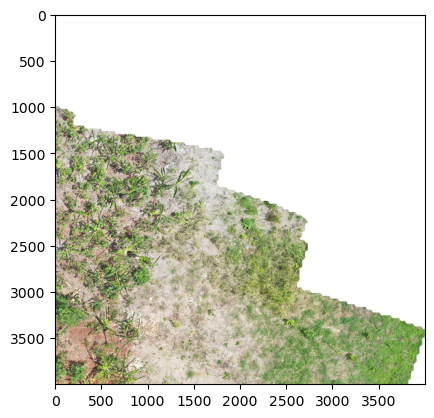

In [33]:
plt.imshow(tile1)
plt.show()

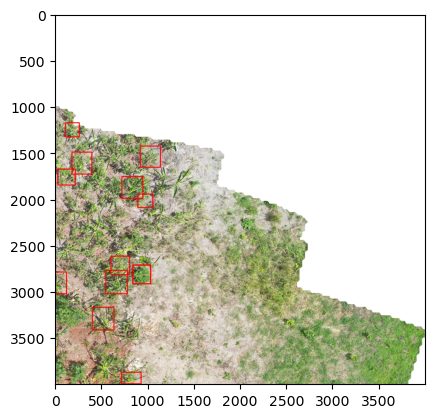

In [34]:
# See the bounding boxes
i = 0
for name in df_img1['img_path'].values:
    
    xmin = round(df_img1['xmin'].values[i])
    ymin = round(df_img1['ymin'].values[i])
    xmax = round(df_img1['xmax'].values[i])
    ymax = round(df_img1['ymax'].values[i])

    color = (255,0,0)
    
    tile1 = cv2.rectangle(tile1,(xmin,ymin),(xmax,ymax),color,10)
    
    i += 1
    #break

plt.imshow(tile1)   

In [35]:
# Function to expand a bounding box into a square
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

In [36]:
# Prepossing module for the images: resize, do random flips, convert to tensor and scale
preprocess = transforms.Compose([
                     transforms.Resize(224),
                     transforms.RandomHorizontalFlip(),
                     transforms.ToTensor()
])
                

In [37]:
# Class to define the dataset

class Trees(Dataset):
    def __init__(self, csv_file, root_dir):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.trees_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.trees_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.trees_frame.iloc[idx, 0])
        image = Image.open(img_name)
        
        xmin = int(self.trees_frame.iloc[idx]['xmin'])
        ymin = int(self.trees_frame.iloc[idx]['ymin'])
        xmax = int(self.trees_frame.iloc[idx]['xmax'])
        ymax = int(self.trees_frame.iloc[idx]['ymax'])

        image = image.crop((xmin, ymin, xmax, ymax))
        image = expand2square(image, (0, 0, 0))
        image = preprocess(image)
        is_banana = self.trees_frame.iloc[idx]['banana']
        sample = image, int(is_banana)

        return sample

In [38]:
# Load the training set of bounded box images
ttrain = Trees(csv_file='mapping/train_small.csv', root_dir='tiles/all_tiles')

In [39]:
# Load the validation set of bounded box images
tvalid = Trees(csv_file='mapping/valid_small.csv', root_dir='tiles/all_tiles')

In [40]:
# Load the test set of bounded box images
ttest = Trees(csv_file='mapping/test.csv', root_dir='tiles/all_tiles')

(array([0.26101456, 0.30207004, 0.88209495, 1.26554536, 1.34440112,
        1.42392079, 1.5152668 , 1.45089251, 1.16988243, 0.38491169]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

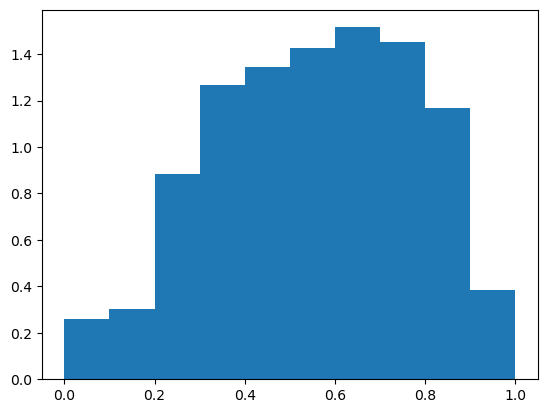

In [41]:
# Visualize how the pixel distribution of an image looks
plt.hist(ttrain[0][0].ravel(), density=True)

is it a banana tree: 0


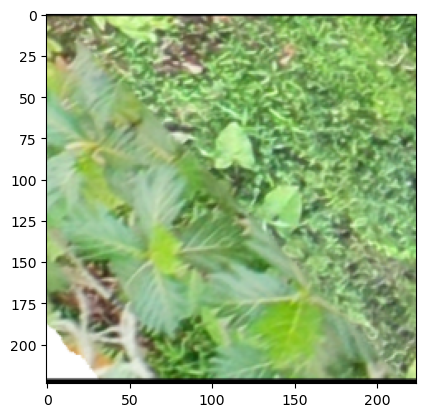

In [42]:
# Check out a training image and its label, 0 is not banana, 1 is banana
im, label = ttrain[1000]
plt.imshow(im.permute(1,2,0))
print('is it a banana tree:',label)

is it a banana tree: 0


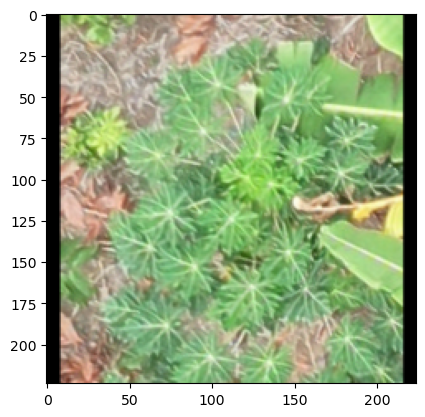

In [43]:
# Check out a validation image and its label
im, label = tvalid[180]
plt.imshow(im.permute(1,2,0))
print('is it a banana tree:',label)

In [44]:
# Make sure the tensor sizes are 3*224*224
for i in range(len(ttrain)):
    sample = ttrain[i]

    print(i, sample[0].shape, sample[1])

    if i == 3:
        break

0 torch.Size([3, 224, 224]) 0
1 torch.Size([3, 224, 224]) 0
2 torch.Size([3, 224, 224]) 0
3 torch.Size([3, 224, 224]) 0


In [ ]:
# Wrap it onto a dataloader

In [45]:
train_dataloader = DataLoader(ttrain, batch_size=128, shuffle=True)

In [46]:
valid_dataloader = DataLoader(tvalid, batch_size=128, shuffle=False)

In [47]:
test_dataloader = DataLoader(ttest, batch_size=128, shuffle=False)

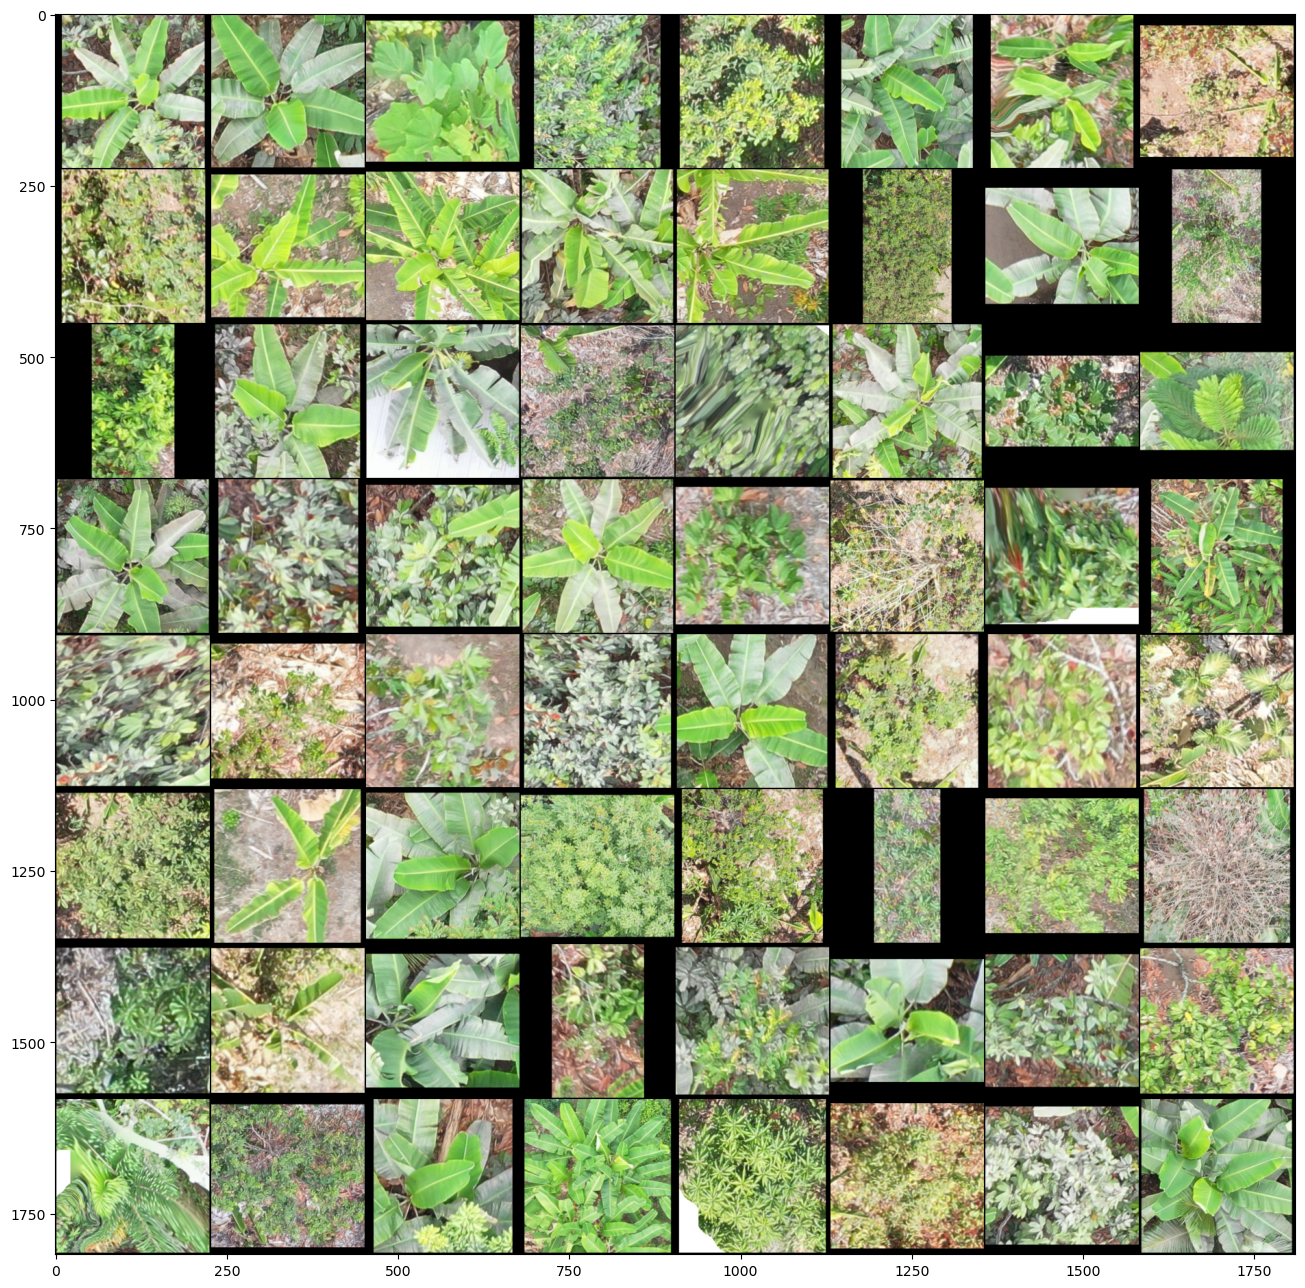

In [48]:
# Check out a sample set of images
samples, labels = next(iter(train_dataloader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:64])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [49]:
# What is the size of the training dataset?
print('Train dataset size:', len(ttrain))

Train dataset size: 2984


In [50]:
# Load resnet-18 model
model = models.resnet18(pretrained=True)

In [93]:
#def set_parameter_requires_grad(model, feature_extracting=True):
#    if feature_extracting:
#        for param in model.parameters():
#            param.requires_grad = False
            
#set_parameter_requires_grad(resnet18, False)

In [94]:
#modelOutputFeats = model.fc.in_features
#modelOutputFeats

In [51]:
# Change the last layers of the model, include dropout to try and help with overfitting.
model.fc = nn.Sequential(
     nn.Dropout(0.5),
     nn.Linear(512, 1)
)

In [55]:
# Set the optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-5, weight_decay= 1e-4, amsgrad = True)

In [56]:
# Set the device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set the loss function
criterion = BCEWithLogitsLoss()

In [57]:
# name of the device
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [58]:
# Do the training here
train_loss = []
train_acc = []

val_loss = []
val_acc = []

precision = []
recall = []
f1 = []

epochs = 15

if torch.cuda.is_available():
    model.cuda()

for epoch in range(epochs):
      print("epoch {}/{}".format(epoch+1,epochs))
      running_loss = 0.0
      running_score = 0.0
      model.train()
      for image,label in train_dataloader:
          image, label = image.to(device), label.to(device)
          label = label.unsqueeze(1)
          optimizer.zero_grad()
          y_pred = model(image)
          loss = criterion(y_pred,label.float())  
          loss.backward() #calculate derivatives 
          optimizer.step() # update parameters
          index = torch.where(y_pred > 0.0, 1, 0)
                
          running_score += torch.sum(index == label.data).item()
          running_loss += loss.item()
      
      epoch_score = running_score/len(train_dataloader.dataset)
      epoch_loss = running_loss/len(train_dataloader.dataset)
      train_loss.append(epoch_loss)
      train_acc.append(epoch_score)
      print("Training loss: {}, accuracy: {}".format(epoch_loss,epoch_score))
      #print("Training loss: {}".format(epoch_loss))
      
      with torch.no_grad():
          model.eval()
          running_loss = 0.0
          running_score = 0.0
          tp = 0.0 
          fp = 0.0
          fn = 0.0
          for image,label in valid_dataloader:
                image = image.to(device)
                label = label.to(device)
                label = label.unsqueeze(1)
                optimizer.zero_grad()
                y_pred = model(image)
                loss = criterion(y_pred,label.float())
                running_loss += loss.item()
                index = torch.where(y_pred > 0, 1, 0)
                
                running_score += torch.sum(index == label.data).item()
                tp_index = torch.where( (index == 1) & (label == 1), 1, 0)
                fp_index = torch.where( (index == 1) & (label == 0), 1, 0)
                fn_index = torch.where( (index == 0) & (label == 1), 1, 0)
                
                tp += torch.sum(tp_index).item()
                fp += torch.sum(fp_index).item()
                fn += torch.sum(fn_index).item()
                
          
          epoch_score = running_score/len(valid_dataloader.dataset)
          epoch_loss = running_loss/len(valid_dataloader.dataset)
          precision_score = tp / (tp + fp)
          recall_score    = tp / (tp + fn)
          f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score)
          
          val_loss.append(epoch_loss)
          val_acc.append(epoch_score)

          precision.append(precision_score)
          recall.append(recall_score)
          f1.append(f1_score)
          print("Validation loss: {}, accuracy: {}".format(epoch_loss,epoch_score))


epoch 1/15
Training loss: 0.004752188781151503, accuracy: 0.6682305630026809
Validation loss: 0.0049903166677613044, accuracy: 0.6219839142091153
epoch 2/15
Training loss: 0.002782103008822845, accuracy: 0.8790214477211796
Validation loss: 0.002568113380398891, accuracy: 0.9021447721179625
epoch 3/15
Training loss: 0.00178408714625535, accuracy: 0.9323056300268097
Validation loss: 0.0015440593416185865, accuracy: 0.9557640750670241
epoch 4/15
Training loss: 0.0013128675011064028, accuracy: 0.9497319034852547
Validation loss: 0.0011372398135649296, accuracy: 0.9611260053619303
epoch 5/15
Training loss: 0.0010080638968313347, accuracy: 0.9597855227882037
Validation loss: 0.0009494958390499248, accuracy: 0.9664879356568364
epoch 6/15
Training loss: 0.0008880703450347879, accuracy: 0.967828418230563
Validation loss: 0.0008952359571533612, accuracy: 0.967828418230563
epoch 7/15
Training loss: 0.0007611844381542213, accuracy: 0.9728552278820375
Validation loss: 0.0008278972152171122, accurac

In [59]:
# Save the model
torch.save(model.state_dict(), 'resnet18-bananaclass-15epochs_lr1e-5_amsgrad.pt')

In [60]:
epochs = range(1, 16, 1)

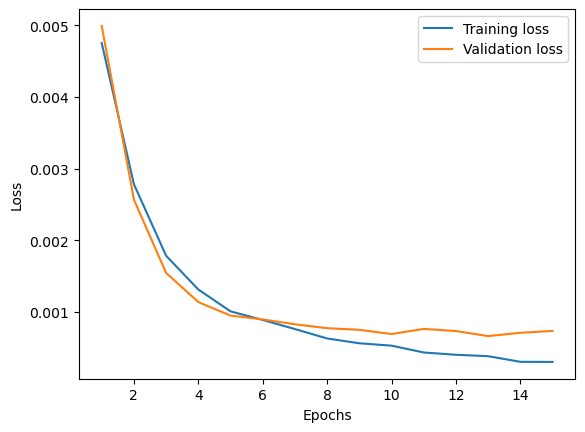

In [61]:
plt.plot(epochs, train_loss, label = 'Training loss')
plt.plot(epochs, val_loss, label = 'Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

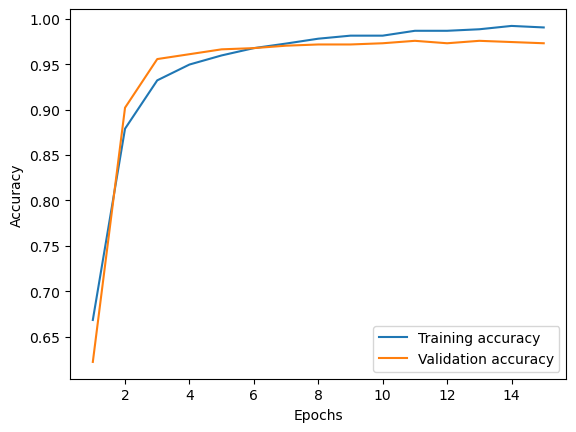

In [62]:
plt.plot(epochs, train_acc, label = 'Training accuracy')
plt.plot(epochs, val_acc, label = 'Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [63]:
precision[-1], recall[-1]

(0.9662447257383966, 0.950207468879668)

In [222]:
recall, precision

([0.975103734439834,
  0.9128630705394191,
  0.9253112033195021,
  0.9294605809128631,
  0.8921161825726142,
  0.9294605809128631,
  0.941908713692946,
  0.941908713692946,
  0.946058091286307,
  0.9128630705394191,
  0.921161825726141,
  0.9336099585062241,
  0.9336099585062241,
  0.9253112033195021,
  0.9294605809128631,
  0.921161825726141,
  0.9253112033195021,
  0.9336099585062241,
  0.921161825726141,
  0.9253112033195021,
  0.9336099585062241,
  0.91701244813278,
  0.9294605809128631,
  0.9294605809128631,
  0.91701244813278,
  0.941908713692946,
  0.9253112033195021,
  0.9087136929460581,
  0.941908713692946,
  0.91701244813278],
 [0.8245614035087719,
  0.9777777777777777,
  0.9780701754385965,
  0.9824561403508771,
  0.9907834101382489,
  0.9911504424778761,
  0.978448275862069,
  0.9826839826839827,
  0.9785407725321889,
  0.9865470852017937,
  0.9866666666666667,
  0.9782608695652174,
  0.9782608695652174,
  0.9780701754385965,
  0.9824561403508771,
  0.9823008849557522,
  0

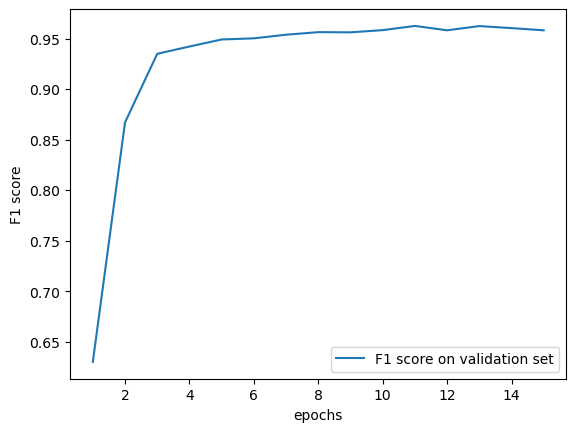

In [65]:
plt.plot(epochs, f1, label = 'F1 score on validation set')
plt.xlabel('epochs')
plt.ylabel('F1 score')
plt.legend()

In [66]:
test_loss = []
test_acc = []
precision_test = []
recall_test = []

with torch.no_grad():
          model.eval()
          running_loss = 0.0
          running_score = 0.0
          tp = 0.0 
          fp = 0.0
          fn = 0.0
          for image,label in test_dataloader:
                image = image.to(device)
                label = label.to(device)
                label = label.unsqueeze(1)
                optimizer.zero_grad()
                y_pred = model(image)
                loss = criterion(y_pred,label.float())
                running_loss += loss.item()
                index = torch.where(y_pred > 0, 1, 0)
                
                running_score += torch.sum(index == label.data).item()
                tp_index = torch.where( (index == 1) & (label == 1), 1, 0)
                fp_index = torch.where( (index == 1) & (label == 0), 1, 0)
                fn_index = torch.where( (index == 0) & (label == 1), 1, 0)
                
                tp += torch.sum(tp_index).item()
                fp += torch.sum(fp_index).item()
                fn += torch.sum(fn_index).item()
                
          
          epoch_score = running_score/len(test_dataloader.dataset)
          epoch_loss = running_loss/len(test_dataloader.dataset)
          precision_score = tp / (tp + fp)
          recall_score    = tp / (tp + fn)
          f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score)
          
          test_loss.append(epoch_loss)
          test_acc.append(epoch_score)

          precision_test.append(precision_score)
          recall_test.append(recall_score)
          #f1.append(f1_score)
          print("Test loss: {}, accuracy: {}".format(epoch_loss,epoch_score))

Test loss: 0.0007472942171005446, accuracy: 0.9785637727759914


In [67]:
precision_test

[0.9546925566343042]

In [68]:
recall_test

[0.9800664451827242]